In [0]:
import numpy as np
import os
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from multiprocessing import cpu_count
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Concatenate
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import SelectPercentile, chi2
import warnings
warnings.filterwarnings("ignore")



## Reading and preprocessing input data

The [Cora](https://linqs.soe.ucsc.edu/data) dataset is used for this task. The dataset consists of 2708 scientific publications classified into one of seven classes. Each publication (node) has features in the form of BoW. The citation network consists of 5429 links. The given citations form a graph. The dataset contains 2 files:
* `cora.content`, which contains the vocabulary of each paper as a BoW.
* `cora.cites`, that includes the ciatations of each paper (links of graph).
Although, one would think that a citation network would be a DAG, since the a cited paper is published before the citing one. However, the given dataset is not, as there exist pairs of publications that cite eachother forming cycles.

In [0]:
def read_files(path):
    
    content_path = os.path.join(path, 'cora.content')
    cites_path = os.path.join(path, 'cora.cites')

    bow = []
    real_idx = {}
    labels = []
    
    with open(content_path, 'r', encoding = 'UTF-8') as file:
        
        for idx, line in enumerate(file):
            
            splt = line.rstrip().split()
            real_idx[int(splt[0])] = idx
            labels.append(splt[-1])
            bow.append([int(x) for x in splt[1:-1]])
            
    bow = np.asarray(bow)
    citations = [[] for _ in range(len(labels))]
    labels_set = set(labels)
    num_classes = len(labels_set)
    label2int, int2label = {}, {}
    for idx, label in enumerate(labels_set):
        label2int[label] = idx
        int2label[idx] = label
    
    labels = np.array([label2int[label] for label in labels])
    labels = keras.utils.to_categorical(labels, num_classes = num_classes)
    num_cited = np.zeros(len(labels))
    num_citing = np.zeros(len(labels))
    
    with open(cites_path, 'r', encoding = 'UTF-8') as file:
        
        for line in file:
            
            cited, citing = [real_idx[int(idx)] for idx in line.rstrip().split()]
            num_cited[cited] += 1
            num_citing[citing] += 1
            
            citations[citing].append(cited)
            
        citations = np.asarray(citations)
            
    return bow, citations, labels, num_cited, num_citing, num_classes
            
            

In [0]:
!wget "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"

--2020-05-13 15:46:47--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167063 (163K) [application/x-gzip]
Saving to: ‘cora.tgz’

cora.tgz            100%[===================>] 163.15K   812KB/s    in 0.2s    

2020-05-13 15:46:48 (812 KB/s) - ‘cora.tgz’ saved [167063/167063]



In [0]:
!tar zxvf cora.tgz

cora/
cora/README
cora/cora.content
cora/cora.cites


In [0]:
path = os.path.join(os.getcwd(), 'cora')
bow, citations, labels, num_cited, num_citing, num_classes = read_files(path)


Every node in the citation graph has at least one edge.

In [0]:
total_cites = num_cited + num_citing
most_isolated = np.argmin(total_cites)
print('Most isolated paper: {} with {} links'.format(most_isolated, total_cites[most_isolated]))
most_connected = np.argmax(total_cites)
print('Most connected paper: {} with {} links'.format(most_connected, total_cites[most_connected]))

Most isolated paper: 1 with 1.0 links
Most connected paper: 163 with 169.0 links


A very basic implementation of [deepwalk](https://arxiv.org/abs/1403.6652). A slight augmentation to the algorithm is that during the random walks, we keep the number of visits to each node. These can be used as weights when we choose a random neighbouring node i.e. nodes visited the least have the largest probability of being visited. This ensures that all the nodes of the graph are visited sufficient amount of times for the embeddings to be generated properly. The inspiration for this trick was [PER](https://arxiv.org/abs/1511.05952).

In [0]:
def deepwalk(adj_list, max_length, num_walks):
    
    num_nodes = adj_list.shape[0]
    num_visits = np.zeros(num_nodes)
    walks = []
    
    for _ in tqdm(range(num_walks)):
        
        node = np.random.randint(num_nodes)
        walk = [node]
        
        while len(walk) < max_length:
        
            if  not len(adj_list[node]):
                break
            
            weights = 1 / (1 + num_visits[adj_list[node]]) ** 0.6
            weights = weights / np.sum(weights)
            node = np.random.choice(adj_list[node], p = weights)
            walk.append(node)
            
        if len(walk) > 1:
            
            num_visits[walk] += 1
            walks.append([str(node) for node in walk])
            
    return num_visits, walks
            
            
        

The following function returns the nodes' embeddings. The embeddings are created by the gensim library. The word2vec function only accepts a list of lists of strings as input, which means that the nodes have to represented as strings rathers than ontegers.

In [0]:
def get_emb_weights(walks, emb_dim, workers, window, epochs, num_nodes):
    
    model = Word2Vec(walks, 
                 min_count=3, 
                 size=emb_dim,                
                 workers=workers,              
                 window=window,   
                 iter=epochs)
    
    os.chdir(path)
    model.wv.save_word2vec_format('model_{}.txt'.format(emb_dim), binary=False)
    
    emb_weights = np.zeros((num_nodes, emb_dim))
    for node in model.wv.vocab:
        emb_weights[int(node)] = model[node]
        
    return emb_weights

The parameters for the training

In [0]:
num_walks = 300000
max_length = 15
min_count = 3
emb_dim = 256
workers = cpu_count()
window = 2
word2vec_epochs = 20
clf_epochs = 50
num_nodes = len(labels)
num_bow = bow.shape[1]

In [0]:
num_visits, walks = deepwalk(citations, max_length, num_walks)

100%|██████████| 300000/300000 [02:02<00:00, 2455.35it/s]


Each node of the graph is visited, although some are visted much more than others. This can be attributed to cycles in the graph formed by publications mutually citing each other.

In [0]:
print('Maximum number of visits to a node: {}'.format(np.max(num_visits)))
print('Minimum number of visits to a node: {}'.format(np.min(num_visits)))


Maximum number of visits to a node: 22538.0
Minimum number of visits to a node: 32.0


In [0]:
emb_weights = get_emb_weights(walks, emb_dim, workers, window, word2vec_epochs, num_nodes)

# First approach: only embeddings as input
---
A very basic NN used to classify a node given only its embedding. In order to minimize overfitting droput is heavily used. I also tried using label_smoothing and selu instead of relu but there were no tangible improvements on the test set.

In [0]:
def create_clf1(dropout, smoothing):
    
    assert 0.0 < dropout < 1.0
    
    embedding_layer = Embedding(input_dim = num_nodes,
                            output_dim = emb_dim,
                            weights=[emb_weights],
                            trainable=False,
                            input_length = 1)
    
    input_ = Input(shape = ())#shape = None)
    x = embedding_layer(input_)
    x = Dense(256, activation = 'relu') (x)
    x = Dropout(dropout) (x)
    x = Dense(128, activation = 'relu') (x)
    x = Dropout(dropout) (x)
    output_ = Dense(num_classes, activation = 'softmax') (x)
    
    clf = Model(inputs = [input_], outputs = [output_])
    
    loss = keras.losses.CategoricalCrossentropy(
        label_smoothing=smoothing)
    
    clf.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])
    
    return clf

In [0]:
clf1 = create_clf1(0.4, 0.0)
print(clf1.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
embedding (Embedding)        (None, 256)               693248    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903   

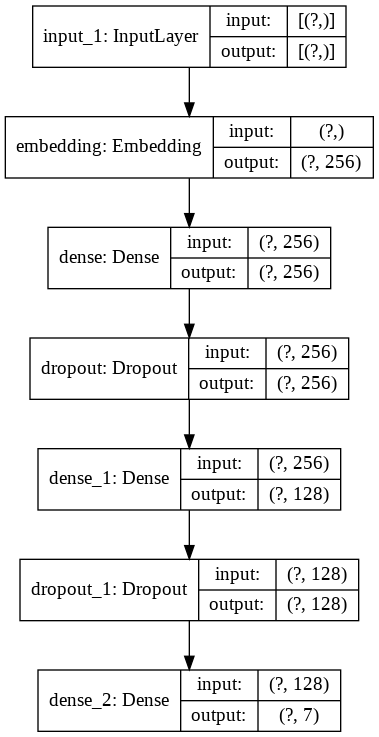

In [0]:
keras.utils.plot_model(clf1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The nodes are randomly split between train set and test set

In [0]:
x = np.arange(num_nodes)

x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size = 0.25)

In [0]:
clf1.fit(x_train, y_train, epochs = 130, batch_size = 32)

Epoch 1/130
64/64 [==============================] - 0s 4ms/step - loss: 1.5646 - accuracy: 0.4505
Epoch 2/130
64/64 [==============================] - 0s 4ms/step - loss: 1.1598 - accuracy: 0.6268
Epoch 3/130
64/64 [==============================] - 0s 4ms/step - loss: 0.9506 - accuracy: 0.6982
Epoch 4/130
64/64 [==============================] - 0s 4ms/step - loss: 0.8415 - accuracy: 0.7312
Epoch 5/130
64/64 [==============================] - 0s 4ms/step - loss: 0.7619 - accuracy: 0.7582
Epoch 6/130
64/64 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.7725
Epoch 7/130
64/64 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.8055
Epoch 8/130
64/64 [==============================] - 0s 4ms/step - loss: 0.5646 - accuracy: 0.8208
Epoch 9/130
64/64 [==============================] - 0s 4ms/step - loss: 0.5412 - accuracy: 0.8370
Epoch 10/130
64/64 [==============================] - 0s 4ms/step - loss: 0.5112 - accuracy: 0.8395
Epoch 11/

On average the first model leads to accuracy of around 0.8 on the test set

In [0]:
clf1.evaluate(x_test, y_test)

22/22 [==============================] - 0s 3ms/step - loss: 1.4967 - accuracy: 0.8035


[1.4966752529144287, 0.8035450577735901]

## Second approach: Embeddings && BoW as input
---
The idea is to to use both the emeddings and the Bag of Words as input to the neural network. However, BoW is very sparse and its dimensions are too large. That is why we reduce the dimensions using SelectPercentile from sklearn.

In [0]:
x = np.arange(num_nodes)
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x, bow, labels, test_size = 0.25)

percentile = SelectPercentile(chi2, percentile=20)
x2_train_reduced = percentile.fit_transform(x2_train, y_train)
mask = percentile.get_support()
num_bow = x2_train_reduced.shape[1]
x2_test_reduced = x2_test[:, mask]


In this model, the embeddings and the reduces BoWs are conctenated as the input to the first fully connected layer.

In [0]:
def create_clf2(dropout):
    
    embedding_layer = Embedding(input_dim = num_nodes,
                            output_dim = emb_dim,
                            weights=[emb_weights],
                            trainable=False,
                            input_length = 1)
    
    input1 = Input(shape = ())#shape = None)
    x1 = embedding_layer(input1)
    
    input2 = Input(shape = (num_bow,))
    x = Concatenate(axis = 1) ([x1, input2])
    
    x = Dense(256, activation = 'relu') (x)
    x = Dropout(dropout) (x)
    x = Dense(128, activation = 'relu') (x)
    x = Dropout(dropout) (x)
    output = Dense(num_classes, activation = 'softmax') (x)
    
    clf = Model(inputs = [input1, input2], outputs = [output])
    
    clf.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return clf

In [116]:
clf2 = create_clf2(0.6)
clf2.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 256)          693248      input_26[0][0]                   
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 287)]        0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 543)          0           embedding_13[0][0]               
                                                                 input_27[0][0]            

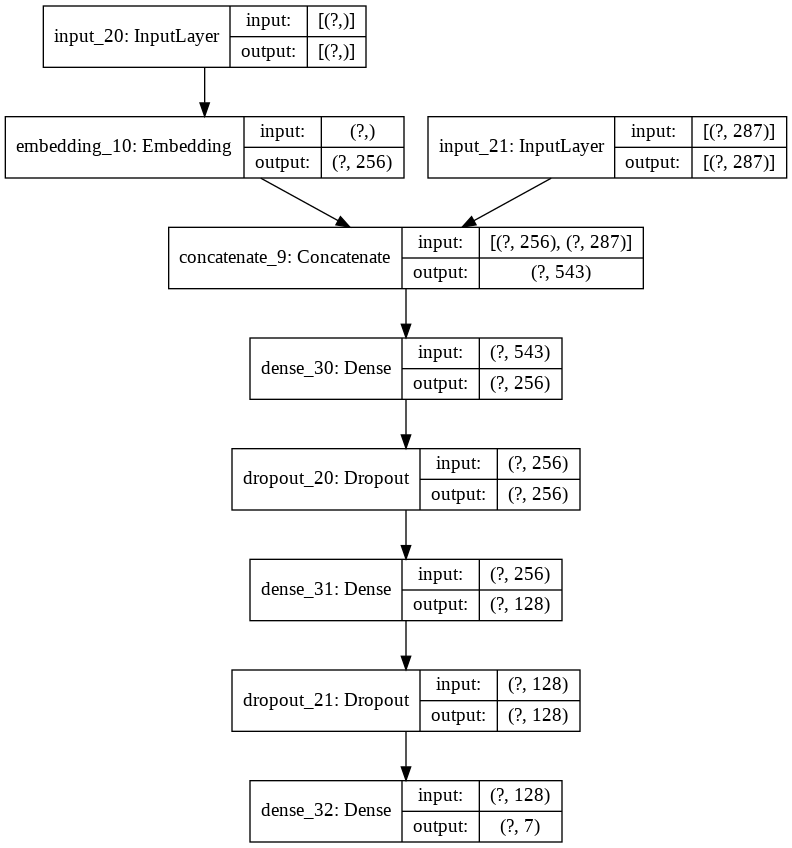

In [0]:
keras.utils.plot_model(clf2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
x = np.arange(num_nodes)

x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x, bow_reduced, labels, test_size = 0.25)

In [0]:
print(x1_train.shape)
print(x1_test.shape)
print(x2_train.shape)
print(x2_test.shape)
print(y_train.shape)
print(y_test.shape)

(2031,)
(677,)
(2031, 512)
(677, 512)
(2031, 7)
(677, 7)


In [120]:
clf2.fit([x1_train, x2_train_reduced],  y_train, epochs = 100, batch_size = 64)

Epoch 1/100
32/32 [==============================] - 0s 4ms/step - loss: 1.0466 - accuracy: 0.7646
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.5266 - accuracy: 0.8351
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4238 - accuracy: 0.8744
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3456 - accuracy: 0.8932
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3198 - accuracy: 0.9025
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.2795 - accuracy: 0.9138
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.2207 - accuracy: 0.9311
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 0.2268 - accuracy: 0.9281
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 0.1863 - accuracy: 0.9404
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 0.1967 - accuracy: 0.9444
Epoch 11/

On average the second model has 0.85 accuracy on the test set, 0.05 better than the first one.

In [121]:
clf2.evaluate([x1_test, x2_test_reduced], y_test)

22/22 [==============================] - 0s 3ms/step - loss: 0.7507 - accuracy: 0.8804


[0.7506995797157288, 0.8803545236587524]